# fbb skeleton notebook for PUI2017 HW6

In [36]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json

#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")
    
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# Download, move and read data

In [10]:
#download, and move data to PUIDATA, and read data in 
#!curl -O https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z
os.system("curl -o energyconsumption.csv https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD")
os.system("mv energyconsumption.csv " + os.getenv('PUIDATA'))
#!mv /Users/cihe/downloads/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv $PUIDATA

0

In [11]:
#!curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip
#!mv /Users/cihe/downloads/mn_mappluto_16v2.zip $PUIDATA
os.system("curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip")
os.system("unzip mn_mappluto_16v2.zip -d " + os.getenv("PUIDATA") + "/Manhattan")

0

In [49]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/energyconsumption.csv")
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

# Data cleaning 

In [50]:
nrg.columns

Index(['BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [51]:
bsize.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord'

In [52]:
bsize.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,MN,1,201,101,1,1000,02,1,10004,E007,...,10101,,0.000000e+00,,1,16V2,0,6306.265838,1.148541e+06,"POLYGON ((973154.7117999941 194614.3315999955,..."
1,MN,9,14,101,9,1013,02,1,10004,L015,...,10101,,1.000090e+09,12/26/1985,1,16V2,0,686.230174,2.373306e+04,"POLYGON ((980492.3622000068 195423.9451999962,..."
2,MN,15,7501,101,13,2005,02,1,10004,E010,...,10101,,1.000150e+09,12/29/1998,1,16V2,7,1098.925676,6.753824e+04,"POLYGON ((979999.0820000023 196493.2800000012,..."
3,MN,13,5,101,13,2008,02,1,10004,E010,...,10101,,0.000000e+00,,1,16V2,0,709.632239,3.068607e+04,"POLYGON ((980424.4003999978 196274.334800005, ..."
4,MN,1,10,101,5,1018,02,1,10004,E007,...,10101,,0.000000e+00,,1,16V2,0,12277.830569,7.550344e+06,"POLYGON ((979561.8711999953 191884.2495999932,..."


In [53]:
bsize.drop([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010', u'SchoolDist',
       u'Council', u'ZipCode', u'FireComp', u'PolicePrct', u'HealthArea',
       u'SanitBoro', u'SanitDistr', u'SanitSub', u'Address', u'ZoneDist1',
       u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1', u'Overlay2',
       u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight', u'SplitZone', u'BldgClass',
       u'LandUse', u'Easements', u'OwnerType', u'OwnerName', u'LotArea', u'BldgArea',
       u'ComArea', u'ResArea', u'OfficeArea', u'RetailArea', u'GarageArea',
       u'StrgeArea', u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs',
       u'NumFloors', u'LotFront', u'LotDepth',
       u'BldgFront', u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
        u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'CommFAR', u'FacilFAR', u'BoroCode',
       u'CondoNo', u'Tract2010', u'XCoord', u'YCoord', u'ZoneMap', u'ZMCode',
       u'Sanborn', u'TaxMap', u'EDesigNum', u'APPBBL', u'APPDate', u'PLUTOMapID',
       u'Version', u'MAPPLUTO_F', u'SHAPE_Leng', u'SHAPE_Area', u'geometry'], axis=1, inplace=True)

In [54]:
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL
0,0,0,1900,1.000010e+09
1,0,0,1987,1.000090e+09
2,500,602,1902,1.000158e+09
3,0,50,1900,1.000130e+09
4,0,0,1900,1.000010e+09


As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## exploratory analysis

/Users/cihe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


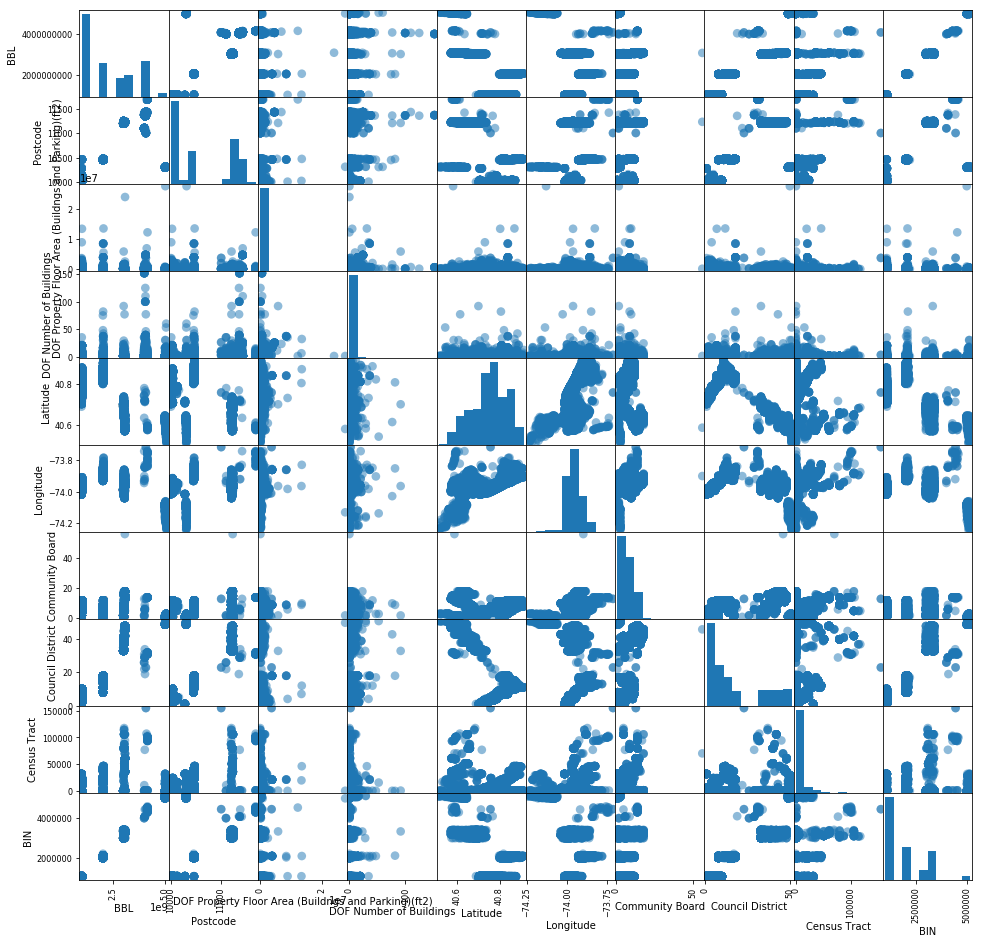

In [55]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones

from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));


# Figure 1: scatter matrix of all numerical values in the files. Not many useful information here,  some of the columns were not even been plotted; some of them might have some correlations like BBL and zipcode, latitude/longitude with district, but I am more interested in energy and building size information. Need to do cleaning on the data. 

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

In [56]:
# make sure you clean up your data and throw away columns you do not need!
nrg.drop([u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)', u'Street Number',
       u'Street Name', u'Borough', 
       u'DOF Benchmarking Submission Status', 
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'Primary Property Type - Self Selected', 
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BIN', u'NTA'], axis=1, inplace=True)

# I use the 'DOF Property Floor Area (Buildngs and Parking)(ft2)' not the 'reported floor area', so some results have a little difference through all the analysis.

In [57]:
nrg.head()

,BBL,Postcode,Site EUI(kBtu/ft2),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
Record Number,,,,,
12086,1.000410e+09,NaN,NaN,NaN,NaN
14354,4.021460e+09,11375.0,NaN,82730.0,1.0
12150,2.027620e+09,NaN,NaN,NaN,NaN
12590,1.006700e+09,10001.0,NaN,440360.0,1.0
15591,2.048300e+09,NaN,NaN,NaN,NaN


In [58]:
nrg.BBL = pd.to_numeric(nrg.BBL)
nrg['Postcode'] = pd.to_numeric(nrg['Postcode'])
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'],errors='coerce')
nrg['DOF Property Floor Area (Buildngs and Parking)(ft2)'] = pd.to_numeric(nrg['DOF Property Floor Area (Buildngs and Parking)(ft2)'])
nrg['DOF Number of Buildings'] = pd.to_numeric(nrg['DOF Number of Buildings'])

In [59]:
# use pd.to_numeric to convert strings to numeric values, 
##check that your conversion worked: e.g.
print (nrg['Site EUI(kBtu/ft2)'].astype(float))
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
bsize.BBL.astype(float)
#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


Record Number
12086      NaN
14354      NaN
12150      NaN
12590      NaN
15591      NaN
12135      NaN
8523       NaN
15920      NaN
14241      NaN
15925      NaN
9685       NaN
7540       NaN
14360      NaN
10588      NaN
14423      NaN
12515      NaN
3028     125.4
14609      NaN
12096      NaN
6666       NaN
8914       NaN
11586      NaN
11714      NaN
14307      NaN
12761      NaN
12091      NaN
16027      NaN
13378      NaN
14911      NaN
15103      NaN
         ...  
13804      NaN
14559      NaN
14560      NaN
14748      NaN
14753      NaN
13582      NaN
13947      NaN
14779      NaN
14409      NaN
13262      NaN
13261      NaN
12523      NaN
12529      NaN
12536      NaN
13929      NaN
13944      NaN
13945      NaN
13821      NaN
13829      NaN
13837      NaN
13838      NaN
13847      NaN
14352      NaN
12976      NaN
12978      NaN
12984      NaN
12987      NaN
12988      NaN
13472      NaN
13482      NaN
Name: Site EUI(kBtu/ft2), Length: 16170, dtype: float64


0        1.000010e+09
1        1.000090e+09
2        1.000158e+09
3        1.000130e+09
4        1.000010e+09
5        1.000010e+09
6        1.000130e+09
7        1.000090e+09
8        1.000030e+09
9        1.000120e+09
10       1.000030e+09
11       1.000168e+09
12       1.000160e+09
13       1.000030e+09
14       1.000120e+09
15       1.000030e+09
16       1.000030e+09
17       1.000130e+09
18       1.000090e+09
19       1.000090e+09
20       1.000300e+09
21       1.000328e+09
22       1.000318e+09
23       1.000080e+09
24       1.000290e+09
25       1.000290e+09
26       1.000390e+09
27       1.000020e+09
28       1.000350e+09
29       1.000070e+09
             ...     
42656    1.008968e+09
42657    1.010778e+09
42658    1.010478e+09
42659    1.013428e+09
42660    1.014298e+09
42661    1.014738e+09
42662    1.018878e+09
42663    1.018438e+09
42664    1.016308e+09
42665    1.018318e+09
42666    1.019448e+09
42667    1.018448e+09
42668    1.019438e+09
42669    1.019448e+09
42670    1

In [60]:
#drop everything you do not need to lighten the memory load on your machine! this is important!! 
#this file has a lot of columnsm most of them you will not need

In [61]:
#How many missing values?
indx = np.isnan(nrg['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN %d"%indx)
#do it for however many columns you need

invalid entries changed to NaN 4623


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). You can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data _type_ is the same:printing the columns the content may look the same but your computer wont know it is the same if it is a different data type (e.g. '1' string is not the same as 1 integer'. '1' == 1 returns False)! both have to be integers, both strings, or whatever, but the same, or you will not be able to merge. 

In [62]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010201.0, 1000410001.0)

In [63]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL').dropna()
bblnrgdata.shape

(4690, 8)

In [64]:
bblnrgdata = bblnrgdata.rename(columns={'Postcode':'Zipcode'})
bblnrgdata.head()

,BBL,Zipcode,Site EUI(kBtu/ft2),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,10022.0,125.4,313200.0,1.0,0,56,1977
15,1.007660e+09,10011.0,122.3,53168.0,1.0,0,8,1912
16,1.008150e+09,10018.0,117.0,364000.0,1.0,0,24,1954
18,1.005050e+09,10013.0,82.1,214110.0,1.0,0,24,1926
19,1.021420e+09,10032.0,137.7,64816.0,1.0,54,62,1924


In [65]:
# prepare your BBL columns
#nrg.rename...
#merge
#bblnrgdata = pd.merge(...)
bblnrgdata.drop([u'Zipcode',u'DOF Number of Buildings'],axis=1,inplace=True)
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),DOF Property Floor Area (Buildngs and Parking)(ft2),UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,125.4,313200.0,0,56,1977
15,1.007660e+09,122.3,53168.0,0,8,1912
16,1.008150e+09,117.0,364000.0,0,24,1954
18,1.005050e+09,82.1,214110.0,0,24,1926
19,1.021420e+09,137.7,64816.0,54,62,1924


/Users/cihe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


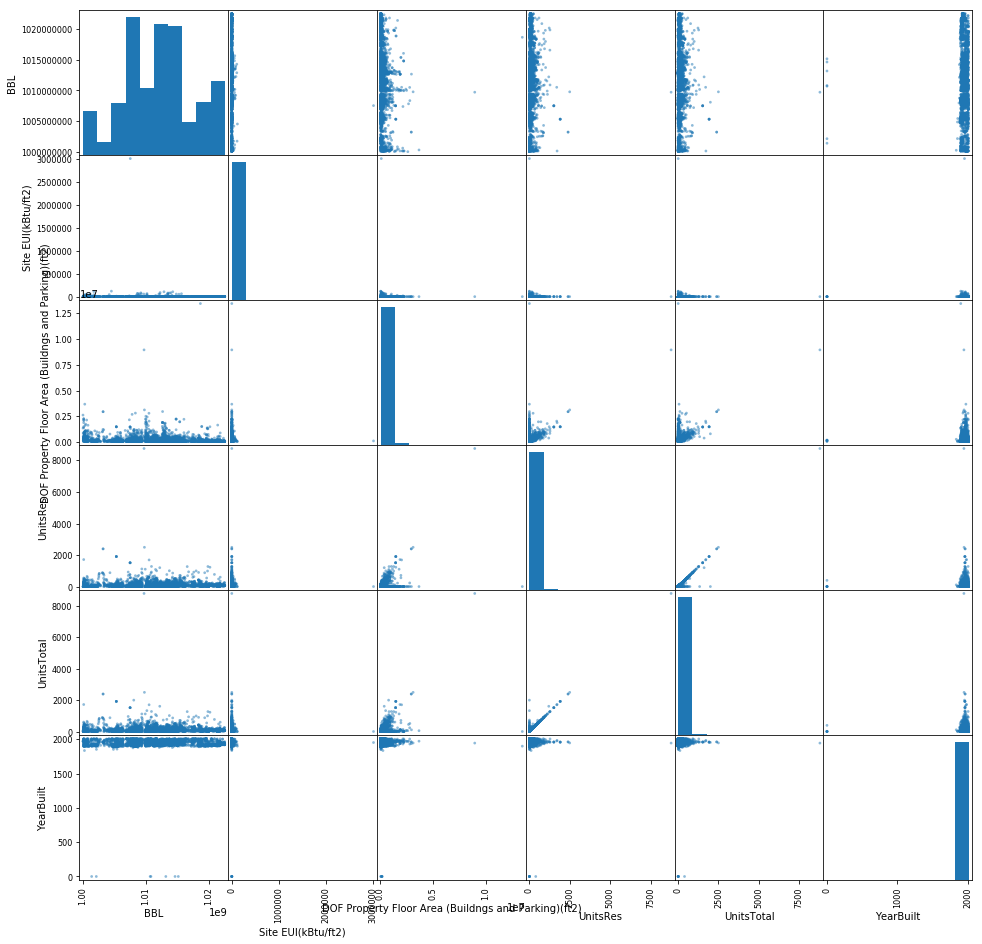

In [66]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16));

# Figure 2: scatter matix of final dataset . we can see some are highly correlated, like units total/units residential or total units/floor areas, other subplots might need to scale down in order to make further interpretation.

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [67]:
bblnrgdata['nrg'] = bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['DOF Property Floor Area (Buildngs and Parking)(ft2)'] 

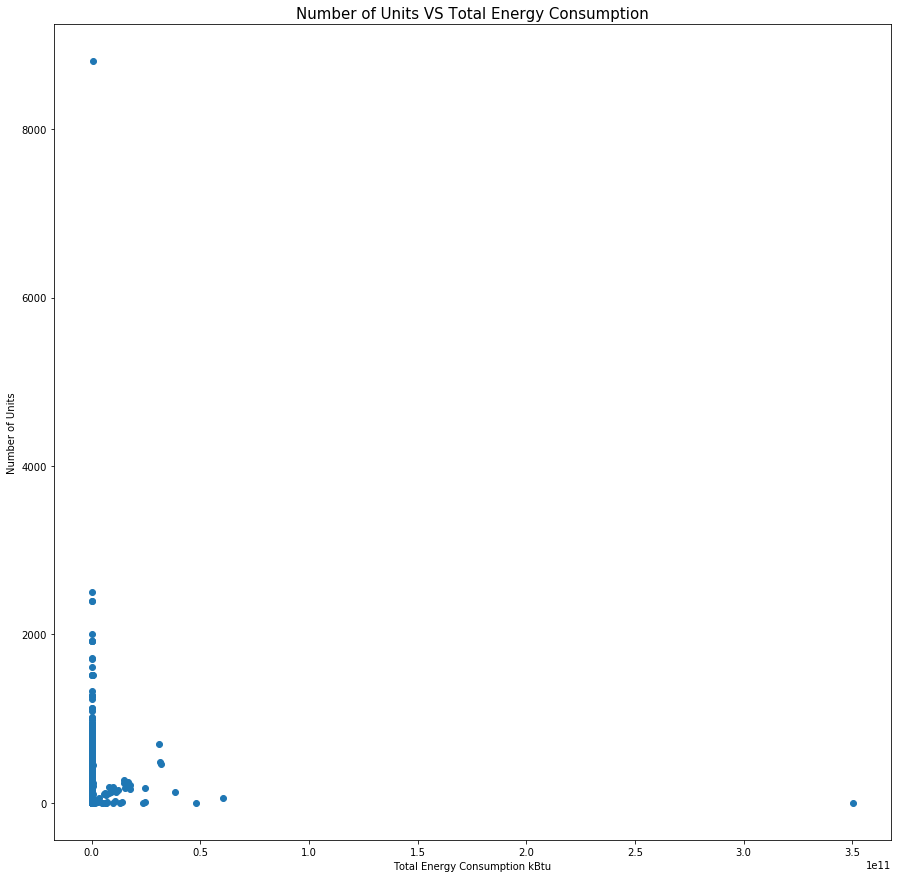

In [68]:
# first scatter plot
pl.figure(figsize=(15,15))
pl.scatter( bblnrgdata['nrg'], bblnrgdata['UnitsTotal'])
pl.title('Number of Units VS Total Energy Consumption', fontsize = 15)
pl.xlabel('Total Energy Consumption kBtu')
pl.ylabel('Number of Units')


# Figure 3. Scatter plot of total units over total energy consumption in a building. Not really any clear relationship due to plot stretching out by the outliers.

(1, 1000)

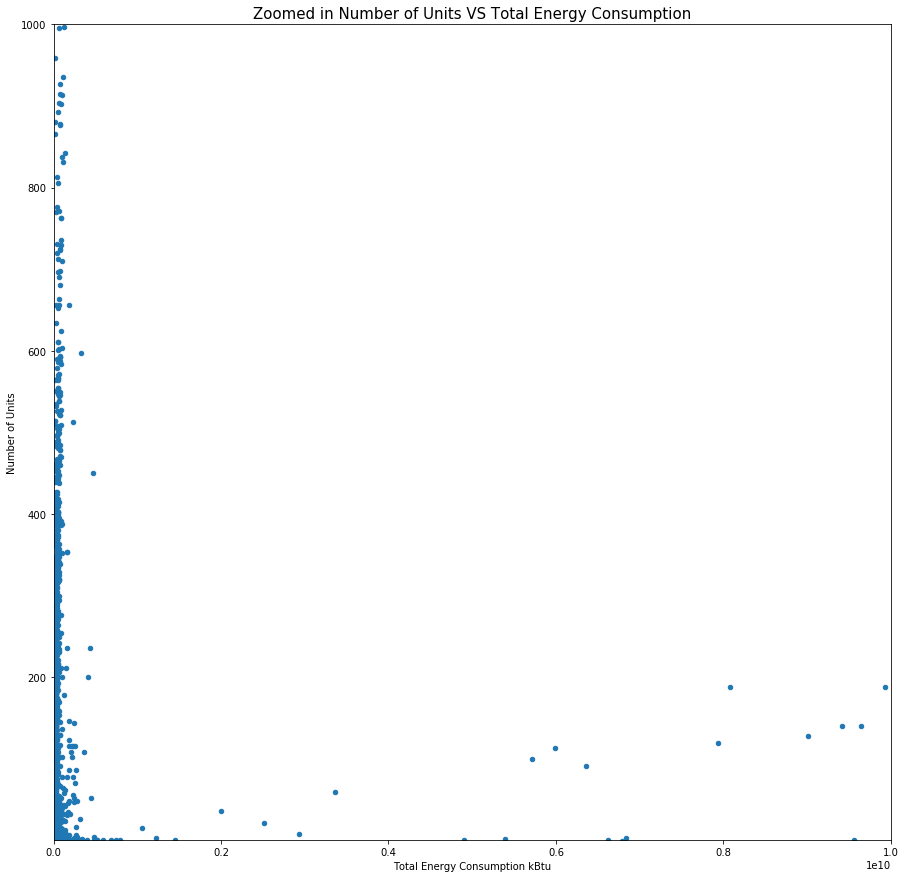

In [69]:
# zoomed in scatter plot
ax = bblnrgdata.plot(kind='scatter', x='nrg', y='UnitsTotal', 
                   marker='o',  figsize=(15, 15))
ax.set_title('Zoomed in Number of Units VS Total Energy Consumption', fontsize = 15)
ax.set_xlabel('Total Energy Consumption kBtu')
ax.set_ylabel('Number of Units')
ax.set_xlim(1000,1e10)
ax.set_ylim(1,1000)

# # Figure 4. Range cut scatter plot of total units over total energy consumption in a building. Still no clear relationship.

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **
**try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and expand the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. You can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000] - see below.

Also I removed the buildings with several thousand units. Points like that at the edge of my range would have a lot of "LEVERAGE", however they are not spurious entries like the 0, which I believe are missing values, or perhaps abandoned lots. These are good datapoint that I need to throw away functionally for my analysis to work, but that should be stated clearly in your report.


In [70]:
#you may need to change the name of this column under some versions of pandas
#(ft²) may throw an error due to the funny character depending on encoding
#bblnrgdata['Reported Property Floor Area (Building(s))'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']

/Users/cihe/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


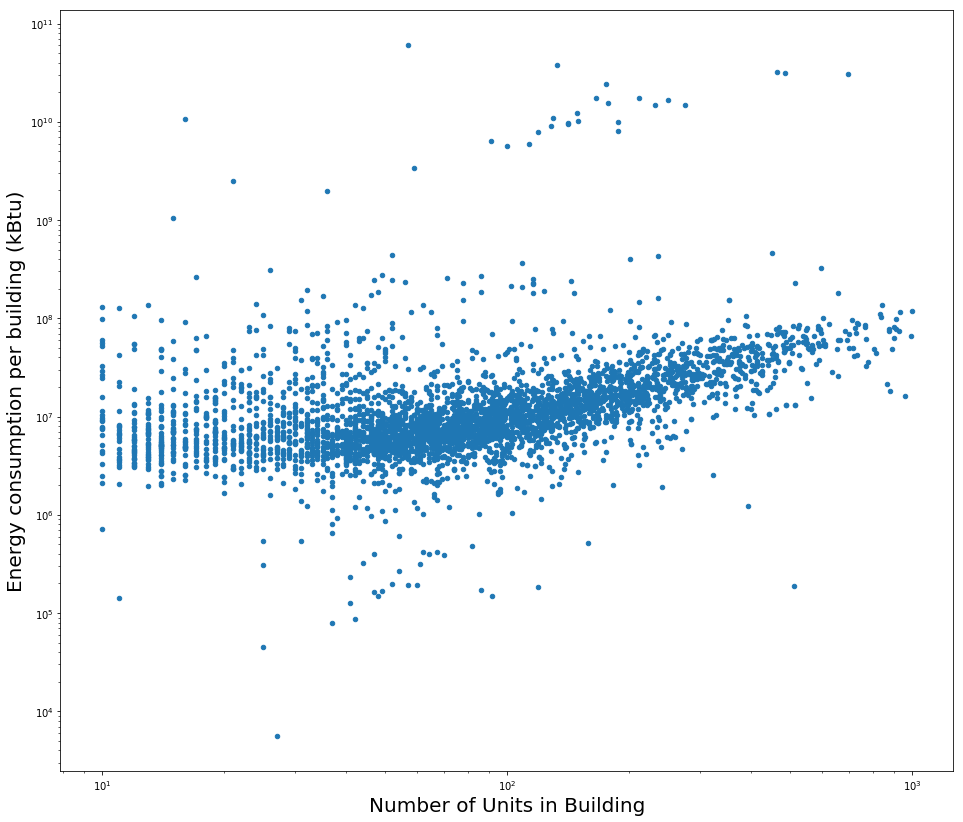

In [71]:
# I have the energy per sq foot in the data, I need the total energy though
#bblnrgdata['nrg'] = ...

bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                           (bblnrgdata.UnitsTotal<1000)]

ax = bblnrgdataCut.plot(kind='scatter', y='nrg', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

# Figure 5. Log-Log transformed scatter plot of total energy consumption over total units in a building. It is positive relation between them.

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [72]:
#X = sm.add_constant(np.log10(x))
#linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN

## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 




1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.
2. **Fit a line** to Energy vs Units.



# DV: total energy per building     IV: total units per building

# 1.unit over energy fit line

In [73]:
# fits and plots here
lm1 = smf.ols(formula='np.log10(UnitsTotal)~np.log10(nrg)',data=bblnrgdataCut,missing='drop').fit()
# your plots should show datapoints (as scatter plot) and models (as lines)
# Make sure your model for the quadratic fit looks right: dont just join the points, you need to sort them first!
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log10(UnitsTotal)   R-squared:                       0.180
Model:                              OLS   Adj. R-squared:                  0.180
Method:                   Least Squares   F-statistic:                     875.4
Date:                  Mon, 23 Oct 2017   Prob (F-statistic):          3.98e-174
Time:                          20:56:57   Log-Likelihood:                -1563.8
No. Observations:                  3994   AIC:                             3132.
Df Residuals:                      3992   BIC:                             3144.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.5532      0.083     -6.677      0.000      -0.716      -0.391
np.log10(nrg)     0.3477      0.012     29.588      0.000       0.325       0.371
==============================================================================
Omnibus:                      170.627   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.278
Skew:                          -0.513   Prob(JB):                     1.07e-42
Kurtosis:                       3.331   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

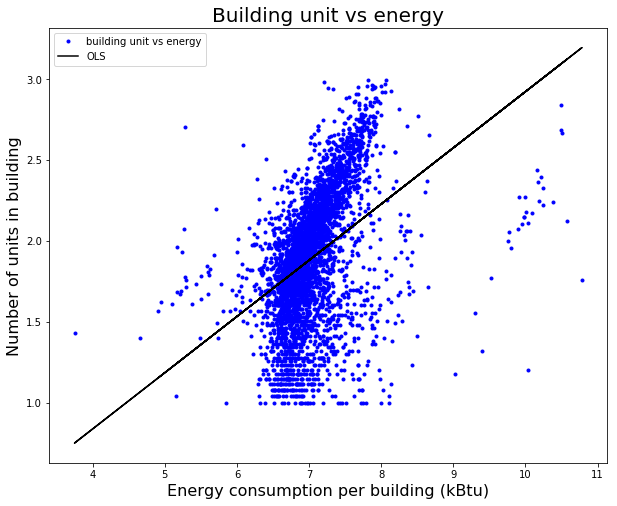

In [74]:
# plot
pl.figure(figsize=(10,8))
pl.plot(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 'b.', label='building unit vs energy')
pl.plot(np.log10(bblnrgdataCut.nrg), lm1.predict(), 'k-', label='OLS')
pl.xlabel('Energy consumption per building (kBtu)', fontsize=16)
pl.ylabel('Number of units in building', fontsize=16)
pl.title('Building unit vs energy', fontsize=20)
pl.legend();

# Figure 6. Log-Log transformed scatter plot of  total units over total energy consumption in a building and the fitted correlation line.
This is not a good fitting. Energy consumption has little variance for most buildings of all units. It will make more sense to fit line with energy over unit.

# 2.energy over unit fit line

In [75]:
lm2 = smf.ols(formula='np.log10(nrg)~np.log10(UnitsTotal)',data=bblnrgdataCut,missing='drop').fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log10(nrg)   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     875.4
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          3.98e-174
Time:                        20:56:58   Log-Likelihood:                -2357.2
No. Observations:                3994   AIC:                             4718.
Df Residuals:                    3992   BIC:                             4731.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.0553      0.034    179.146      0.000       5.989       6.122
np.log10(UnitsTotal)     0.5173      0.017     29.588      0.000       0.483       0.552
==============================================================================
Omnibus:                     2186.475   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46221.571
Skew:                           2.156   Prob(JB):                         0.00
Kurtosis:                      19.098   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

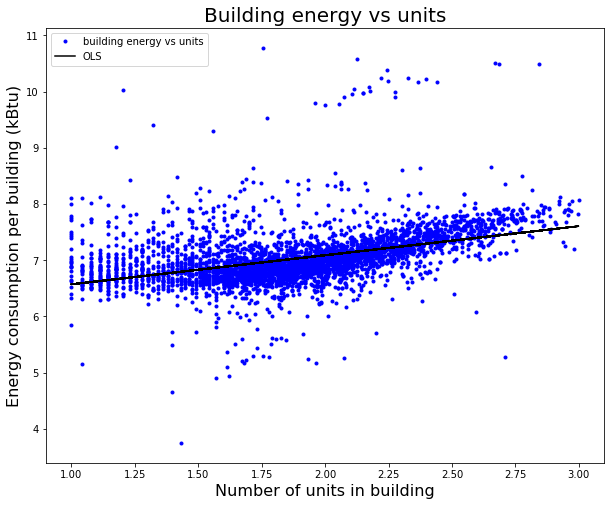

In [76]:
# plot
pl.figure(figsize=(10,8))
pl.plot(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 'b.', label='building energy vs units')
pl.plot(np.log10(bblnrgdataCut.UnitsTotal), lm2.predict(), 'k-', label='OLS')
pl.xlabel('Number of units in building', fontsize=16)
pl.ylabel('Energy consumption per building (kBtu)', fontsize=16)
pl.title('Building energy vs units', fontsize=20)
pl.legend();

# Figure 7. Log-Log transformed scatter plot of total energy consumption over total units in a building and the fitted correlation line.
The model has better fit line and indicates the upward tendency of energy consumption as units number increases.

**Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

    The function is :
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value  model($x_i$) is the prediction, data($x_i$) the observation,
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors?? see next point)
    
*Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.




In [77]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

propagation of errors on the log:https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [78]:
#error of total energy
error_energy = np.sqrt(bblnrgdataCut['Site EUI(kBtu/ft2)']**2+bblnrgdataCut['DOF Property Floor Area (Buildngs and Parking)(ft2)']**2)
#error of total units
error_unit = np.sqrt(bblnrgdataCut.UnitsTotal)

In [88]:
bblnrgdataCut['error_logenergy'] = np.abs(error_energy/bblnrgdataCut.nrg/np.log(10))
bblnrgdataCut['error_logunit'] = np.abs(error_unit/bblnrgdataCut.UnitsTotal/np.log(10))

/Users/cihe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/cihe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [92]:
chi2(np.log10(bblnrgdataCut.nrg), lm1.predict(), bblnrgdataCut.error_logenergy)

21014894240563.65

In [93]:
chi2(np.log10(bblnrgdataCut.nrg), lm2.predict(), bblnrgdataCut.error_logenergy)

3562672370747.4897

# The two models are not nested, wont be able to do likelyhood ratio test between them.

**Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

**Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * log(Likelihood_Model1 / Likelihood_Model2) 

    or equivalently
        
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2) 
    
    where Model1 is the _least complex_ (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels. (Model1.llf)
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferable to Model2. The LR is chi^2 distributed with number of degrees of freedom $N_{DOF}$ = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



In [94]:
lm3 = smf.ols(formula='np.log10(nrg)~np.log10(UnitsTotal)+I(np.log10(UnitsTotal)**2)',data=bblnrgdataCut,missing='drop').fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log10(nrg)   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     638.3
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          3.03e-241
Time:                        21:06:59   Log-Likelihood:                -2198.9
No. Observations:                3994   AIC:                             4404.
Df Residuals:                    3991   BIC:                             4423.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        8.0713      0.116     69.719      0.000       7.844       8.298
np.log10(UnitsTotal)            -1.6927      0.123    -13.766      0.000      -1.934      -1.452
I(np.log10(UnitsTotal) ** 2)     0.5796      0.032     18.144      0.000       0.517       0.642
==============================================================================
Omnibus:                     2363.237   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62495.744
Skew:                           2.330   Prob(JB):                         0.00
Kurtosis:                      21.810   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

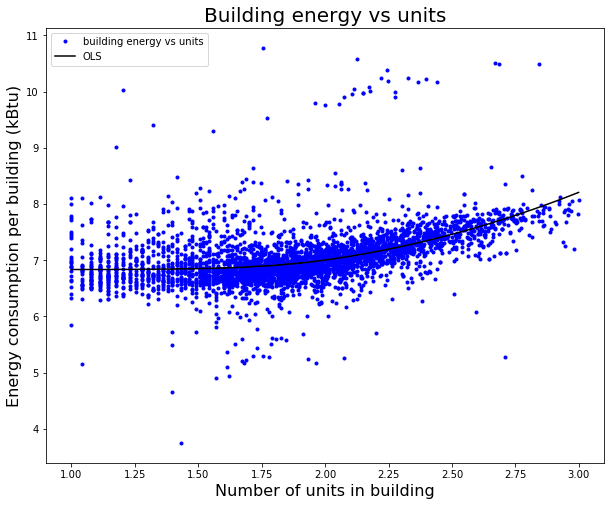

In [97]:
# plot
pl.figure(figsize=(10,8))
pl.plot(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 'b.', label='building energy vs units')
pl.plot(np.log10(bblnrgdataCut.UnitsTotal).sort_values(), lm3.fittedvalues.sort_values(), 'k-', label='OLS')
pl.xlabel('Number of units in building', fontsize=16)
pl.ylabel('Energy consumption per building (kBtu)', fontsize=16)
pl.title('Building energy vs units', fontsize=20)
pl.legend();

# Figure 8.  Log-Log transformed scatter plot of total energy consumption over total units in a building and the fitted quadratic line. The quadratic model fits better to the observations since has better flexibility.

H_0: The simpler model, linear model (lm2), is nested in the more complex curve model (lm3); has equal or better fit.

In [100]:
print ("LR : ", -2 * (lm2.llf - lm3.llf))
print ("LR from statsmodels:", lm3.compare_lr_test(lm2)[0])

LR :  316.557432963
LR from statsmodels: 316.557432963


316.56 hs exceeded the 0.05 threshold 3.84, H0, rejected, lm3 has better fit.

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

In [117]:
#residual calculation function
def residuals(b,a,data,errors=None):
    return((np.log(data.nrg) - np.log(data.UnitsTotal)*a+b )**2 / errors**2).sum()

In [118]:
lm2.params

Intercept               6.055266
np.log10(UnitsTotal)    0.517292
dtype: float64

In [119]:
# init variables
b = lm2.params[0] # intercept
a = lm2.params[1] # slope

intercept = np.arange(-100, 100, 1)      
slope = np.arange(-50.0, 50.0, 0.5)  

In [120]:
Lsurface = np.zeros((len(intercept), len(slope)))
for i,b in enumerate(intercept):
    for j,a in enumerate(slope):
         Lsurface[i][j] = np.nansum(residuals(b, a, bblnrgdataCut, bblnrgdataCut.error_logenergy))

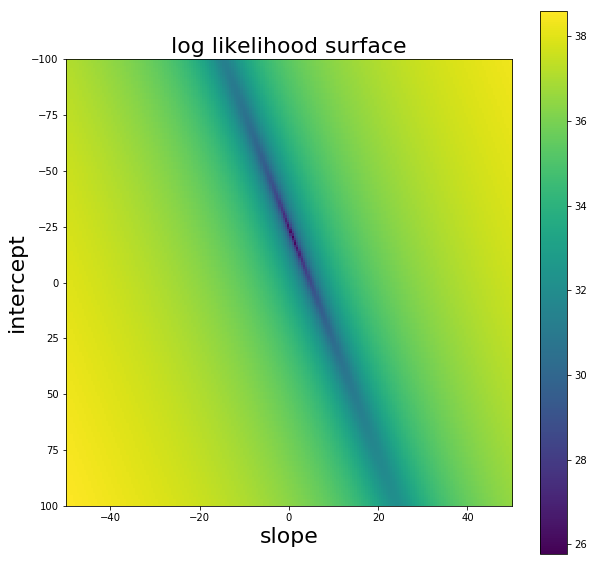

In [121]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

/Users/cihe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


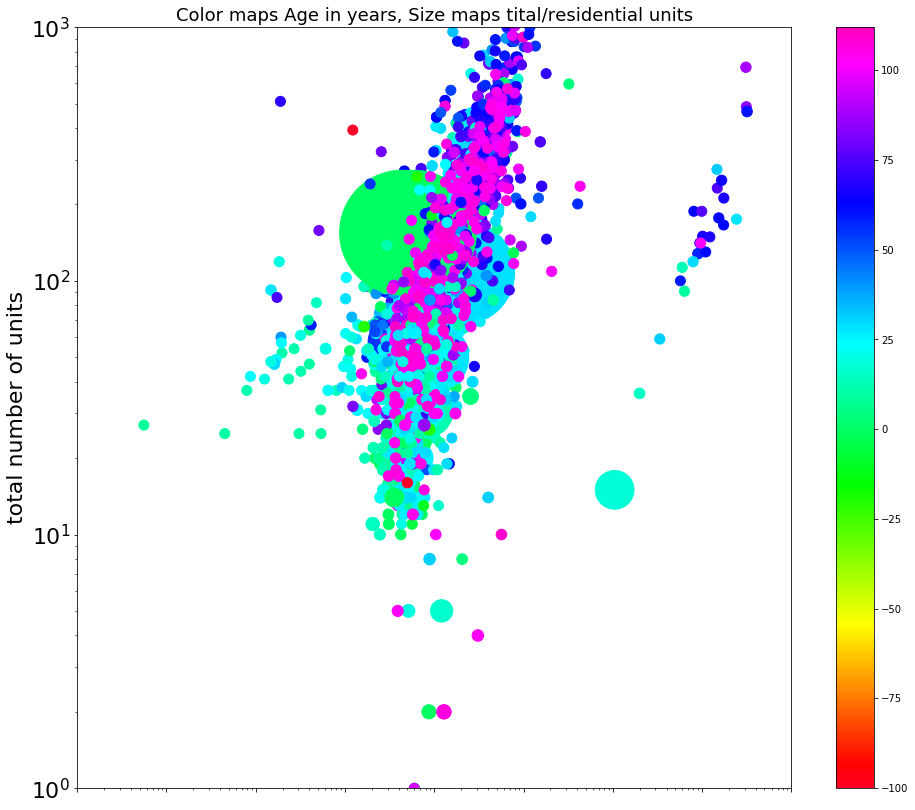

In [49]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)

**I am trying to map the building age to a colormap and the energy consumption per sqare ft to the size of the datapoint.

/Users/cihe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


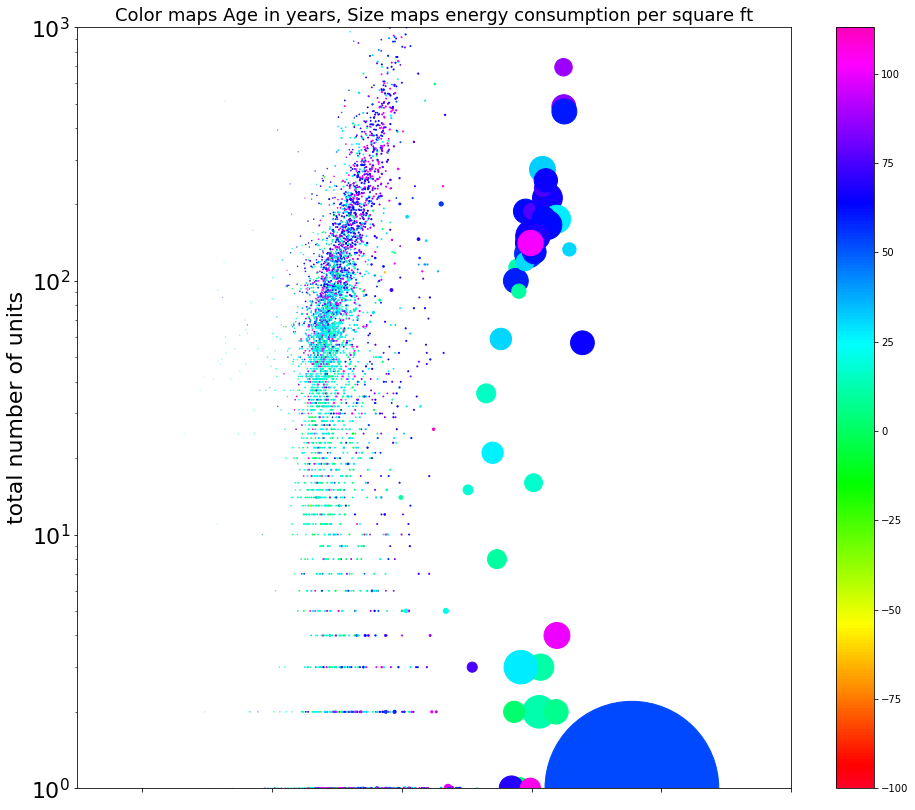

In [53]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e14), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['Site EUI(kBtu/ft2)']/100)
pl.title('Color maps Age in years, Size maps energy consumption per square ft', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)